In [1]:
import random
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import random
import math
import pandas as pd


# константы генетического алгоритма
POPULATION_SIZE = 1000   # количество индивидуумов в популяции
P_CROSSOVER = 0.9       # вероятность скрещивания
P_MUTATION = 0.1        # вероятность мутации индивидуума
MAX_GENERATIONS = 5000    # максимальное количество поколений

In [2]:
HISTORY = []

LAMDA0 = 0.00001
K = 50
v = 100
Time = 1000
# (Т_огр)T0 = T_lim
T_lim = 350

e_1 = 4
e_1i = 2
e_tr = 6
e_tri = 2

{(0, 1): Text(-0.09090909090909094, -0.36363636363636365, '1000'),
 (0, 2): Text(-0.20454545454545459, -0.3068181818181818, '500'),
 (0, 3): Text(-0.7727272727272727, -0.13636363636363638, '1000'),
 (1, 5): Text(0.7045454545454545, -0.25, '500'),
 (2, 5): Text(0.5909090909090908, -0.19318181818181818, '300'),
 (3, 4): Text(-0.4886363636363637, 0.03409090909090907, '500'),
 (4, 5): Text(0.07954545454545447, -0.07954545454545456, '300'),
 (5, 6): Text(0.42045454545454536, 0.034090909090909075, '100'),
 (6, 7): Text(-0.03409090909090916, 0.1477272727272727, '100'),
 (6, 8): Text(0.13636363636363627, 0.3181818181818181, '100'),
 (6, 9): Text(0.13636363636363627, 0.26136363636363635, '50'),
 (7, 8): Text(-0.1477272727272728, 0.26136363636363635, '100'),
 (8, 9): Text(0.022727272727272645, 0.375, '50')}

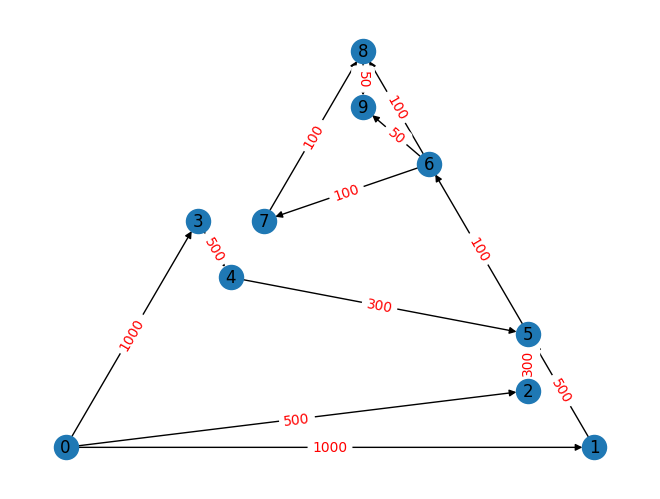

In [3]:
martx = [
[0, 1000, 500, 1000, 0, 0, 0, 0, 0, 0], 
[0, 0, 0, 0, 0, 500, 0, 0, 0, 0], 
[0, 0, 0, 0, 0, 300, 0, 0, 0, 0], 
[0, 0, 0, 0, 500, 0, 0, 0, 0, 0], 
[0, 0, 0, 0, 0, 300, 0, 0, 0, 0], 
[0, 0, 0, 0, 0, 0, 100, 0, 0, 0], 
[0, 0, 0, 0, 0, 0, 0, 100, 100, 50], 
[0, 0, 0, 0, 0, 0, 0, 0, 100, 0], 
[0, 0, 0, 0, 0, 0, 0, 0, 0, 50], 
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
] 

tasks_graph = nx.DiGraph(np.array(martx))
task_weight = [100, 300, 300, 300, 200, 150, 100, 100, 200, 100]

pos = nx.planar_layout(tasks_graph)
nx.draw(tasks_graph, pos, with_labels=True)
nx.draw_networkx_edge_labels(tasks_graph, pos, {(x, y): z['weight'] for (x, y, z) in nx.to_edgelist(tasks_graph)},font_color='red')

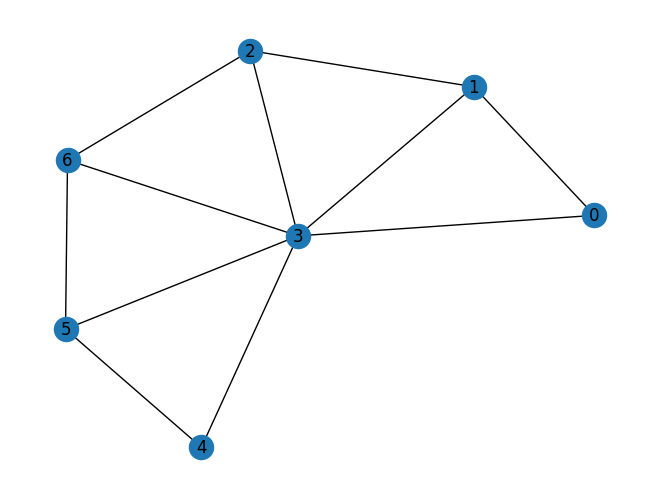

In [4]:
martx = [
    [0, 1, 0, 1, 0, 0, 0], 
    [1, 0, 1, 1, 0, 0, 0], 
    [0, 1, 0, 1, 0, 0, 1], 
    [1, 1, 1, 0, 1, 1, 1], 
    [0, 0, 0, 1, 0, 1, 0], 
    [0, 0, 0, 1, 1, 0, 1], 
    [0, 0, 1, 1, 0, 1, 0], 
] 

network_graph = nx.Graph(np.array(martx))
net_power = [500, 500, 200, 200, 500, 500, 1000]
epsi = [1, 1, 1, 1, 1, 1, 1]
nx.draw(network_graph, with_labels=True)

In [5]:
RANDOM_SEED = 165
random.seed(RANDOM_SEED)

In [6]:
def FLamda(D):
    return LAMDA0 * 2 ** (K * D / 10)


def P(lamda):
    return math.exp(-lamda * Time)


def F(p, epsi):
    res = 1
    for i in range(len(p)):
        if p[i] > 0:
            res *= p[i] ** epsi[i]
    return res

In [7]:
class Individual():
    def __init__(self, *args):
        super().__init__(*args)
        self.f = 0
        self.E = 100000000
        self.W = []
        self.T_task = 0
        self.T_NET = 0
        self.distribution = []
        self.short_path = []

    def __str__(self):
        return f'''f: {self.f}, E: {self.E}, Распределение: {self.distribution}, Нагруженность на узлы: {self.W}'''

    def node_from_distribution(self, node):
        for i in range(len(self.distribution)):
            if node in self.distribution[i]:
                return i
            
    def set_paths(self, paths):
        self.paths = paths

    def set_distribution(self, distribution):
        self.distribution = distribution

    def create_random_distribution(self, COUNT_NODE_NET, COUNT_NODE_TASK, CONST_DISTRIBUTION={}):
        random_task_distribution = [[] for _ in range(COUNT_NODE_NET)]
        temp = [x for x in range(COUNT_NODE_TASK)]
        for node, task in CONST_DISTRIBUTION.items():
            random_task_distribution[node].append(temp.pop(task))
        while not len(temp) == 0:
            random_task_distribution[random.randint(0, COUNT_NODE_NET - 1)].append(
                temp.pop(random.randint(0, len(temp) - 1)))
        self.set_distribution(random_task_distribution)

    def create_paths(self):
        # 'Задача1задача2:ПутьВГрафеСети'
        self.paths = {}
        # Словарь путей
        # Задача:Узел
        self.relationship = {}
        for start, end, weight in nx.to_edgelist(tasks_graph):
            self.relationship[start] = self.node_from_distribution(start)
            self.relationship[end] = self.node_from_distribution(end)
            if self.relationship[start] == self.relationship[end]:
                self.paths[str(start) + str(end)] = [self.relationship[start]]
            else:
                self.paths[str(start) + str(end)] = random.choice(
                    [item for item in nx.all_shortest_paths(network_graph, self.relationship[start], self.relationship[end])])

    def calculation_of_parameters(self):
        # Подсчет трудоемкости
        W = [0 for _ in range(len(net_power))]

        # Сколько каждый узел должен обработать задач 
        v_task_to_node = [0 for _ in range(len(net_power))]
        # Сколько каждый узел должен отправить
        v_sent_to_node = [0 for _ in range(len(net_power))]
        # Сколько каждый узел должен принять 
        v_reseive_to_node = [0 for _ in range(len(net_power))]

        for start, end, weight in nx.to_edgelist(tasks_graph):
            """
            start - задача начало
            end - задача конец
            weight - то сколько должено быть прередано из одной задачи в другую 
            """
            if not len(self.paths[str(start) + str(end)]) == 1:
                temp = self.paths[str(start) + str(end)].copy()
                # task_weight - нагрузка на выполнение задачи 
                #Оброботка нагрузки начала пути 
                W[temp[0]] += task_weight[start] + weight['weight']

                v_sent_to_node[temp[0]] += weight['weight']
                v_task_to_node[temp[0]] += task_weight[start]
                #Оброботка нагрузки конца пути
                W[temp[-1]] += task_weight[end] + weight['weight']

                v_reseive_to_node[temp[-1]] += weight['weight']
                v_task_to_node[temp[-1]] += task_weight[start]

                temp.pop(0)
                temp.pop(-1)
                # Оброботка нагрузки всех остальных узлов в пути
                for i in temp:
                    W[i] += 2 * weight['weight']
                    v_sent_to_node[temp[0]] += weight['weight']
                    v_reseive_to_node[temp[-1]] += weight['weight']
            else:
                W[self.relationship[start]] += task_weight[start]
                v_task_to_node[self.relationship[start]] += task_weight[start]

                W[self.relationship[end]] += task_weight[end]
                v_task_to_node[self.relationship[end]] += task_weight[start]

        # Оценка времени задач изначально
        arr = ([a for a in nx.all_simple_paths(tasks_graph, 0, len(task_weight) - 1)])
        arr.sort(key=lambda x: len(x), reverse=True)
        T_task = [0 for _ in range(len(task_weight))]

        for task in arr[0]:
            T_task[task] = T_lim / len(arr[0])

        # Оценка времени задач
        for path_task in arr[1:]:
            sum_t = 0
            temp = []
            for task in path_task:
                if T_task[task] == 0:
                    temp.append(task)
                sum_t += T_task[task]
            for task in temp:
                T_task[task] = (T_lim - sum_t) / len(temp)

        T_NET = [0 for _ in range(len(net_power))]
        # Оценка времени сети
        for start, end, weight in nx.to_edgelist(tasks_graph):
            path_net = self.paths[str(start) + str(end)].copy()
            if len(path_net) == 1:
                if T_NET[path_net[-1]] == 0:
                    T_NET[path_net[-1]] = min(T_task[end], T_task[start])
                else:
                    T_NET[path_net[-1]] = min(T_task[end], T_task[start], T_NET[path_net[-1]])
            else:
                # Обработка поледего узла в пути
                if T_NET[path_net[-1]] == 0:
                    T_NET[path_net[-1]] = T_task[end]
                else:
                    T_NET[path_net[-1]] = min(T_task[end], T_NET[path_net[-1]])
                # Если будет > 1 узла то
                for node in path_net[:-1]:
                    if T_NET[node] == 0:
                        T_NET[node] = T_task[start] / len(path_net[:-1])
                    else:
                        T_NET[node] = min(T_NET[node], T_task[start] / len(path_net[:-1]))
            
            D = [0. for i in range(len(net_power))]

            for i in range(len(net_power)):
                if not T_NET[i] == 0:
                    D[i] = W[i] / (net_power[i] * T_NET[i])

        # Оценка кр. пути задач для сети
        special_t = T_lim / len(arr[0])
        for node in range(len(net_power)):
            if len(set(self.distribution[node]) & set(arr[0])) > 1:
                T_NET[node] = special_t * len(set(self.distribution[node]) & set(arr[0]))
        flag = True
        for d in D:
            if d > 1:
                flag = False
        
        if flag:
            lamda = [FLamda(D[i]) for i in range(len(net_power))]
            p = [P(L) for L in lamda]
            f = F(p, epsi)
        else:
            f = -1

        #Вычислительного устройства(ВУ). computing devices - cd
        E_cd = [0 for _ in range(len(net_power))]
        #Устройства передачи данных (УПД). data transmission devices - dtd
        E_dtd = [0 for _ in range(len(net_power))]

        for i in range(len(net_power)):
            E_cd[i] = e_1 * (v_task_to_node[i]/net_power[i]) + e_1 * (v_reseive_to_node[i]/net_power[i]) + e_1 * (v_sent_to_node[i]/net_power[i]) - e_1i*(T_lim - (v_task_to_node[i]/net_power[i]) +  (v_reseive_to_node[i]/net_power[i]) + (v_sent_to_node[i]/net_power[i]))
        for i in range(len(net_power)):
            E_dtd[i] = e_tr * (v_reseive_to_node[i]/v) + e_tr * (v_sent_to_node[i]/v) + e_tri * (T_lim - (v_reseive_to_node[i]+v_sent_to_node[i])/v)

        if flag: 
            E = sum(E_cd) + sum(E_dtd)
        else:
            E = 10000000000
        
        self.f = f
        self.E = E
        self.W = W
        self.D = D
        self.T_task = T_task
        self.T_NET = T_NET
        self.short_path = arr[0]

In [8]:
def oneMaxFitness(individual):
    for d in individual.D:
        if d > 1:
            return 0,
    return individual.f, # кортеж

In [9]:
def individualCreator():
    temp = Individual()
    temp.create_random_distribution(len(net_power), len(task_weight))
    temp.create_paths()
    temp.calculation_of_parameters()
    return temp
 
def populationCreator(n = 0):
    return list([individualCreator() for i in range(n)])

In [10]:
population = populationCreator(n=POPULATION_SIZE) 
generationCounter = 0

In [11]:
maxFitnessValues = []
meanFitnessValues = []

In [12]:
def selTournament(population, p_len):
    offspring = []
    for n in range(p_len):
        i1 = i2 = i3 = 0
        while i1 == i2 or i1 == i3 or i2 == i3:
            i1, i2, i3 = random.randint(0, p_len-1), random.randint(0, p_len-1), random.randint(0, p_len-1)
            
        offspring.append(max([population[i1], population[i2], population[i3]], key=lambda ind: ind.f))
        
    return offspring

In [13]:
fitnessValues = [individual.f for individual in population]

In [14]:
def dominates(m1, m2): 
    return m1.f >= m2.f and m1.E <= m2.E

def crossing(p1,p2):
    #Скрещивание распределения
    new_distr = random.choices(range(len(task_weight)), k=random.randint(1,len(task_weight)))
    dist1, dist2 = p1.distribution, p2.distribution
    for task in new_distr:
        i1,i2 = p1.node_from_distribution(task), p2.node_from_distribution(task)
        if not i1 == i2:
            dist1[i1].remove(task); dist2[i2].remove(task)
            dist1[i2].append(task); dist2[i1].append(task)

    child1 = Individual()
    child1.set_distribution(dist1)
    child1.create_paths()
    child1.calculation_of_parameters()
    child2 = Individual()
    child2.set_distribution(dist2)
    child2.create_paths()
    child2.calculation_of_parameters()

    return [child1, child2]

def mutation(mutant, indpb=0.01):
    for task in range(len(task_weight)):
        if random.random() < indpb:
            i = mutant.node_from_distribution(task)
            mutant.distribution[i].remove(task)
            j = -1
            while j == i:
                j = random.randint(0, len(net_power))
            mutant.distribution[i].append(task)

In [15]:
while generationCounter < MAX_GENERATIONS:
    generationCounter += 1

    P_t = population[:]
    Q_t = []

    # Скрещивание 
    while len(Q_t) < POPULATION_SIZE:
        parent1 = random.choice(population)
        parent2 = random.choice(population)

        if random.random() < P_CROSSOVER:
            Q_t+=crossing(parent1, parent2)
    
    # Мутация  
    for ind in Q_t:
        if random.random() < P_MUTATION:
            mutation(ind, indpb=1.0/len(task_weight))

    R_t = P_t + Q_t

    rank = [0 for _ in range(len(R_t))]
    for i in range(len(R_t)):
            for j in range(i+1, len(R_t)):
                if dominates(R_t[i], R_t[j]):
                    rank[j] += 1
                elif dominates(R_t[j], R_t[i]):
                    rank[i] += 1

    F_rank = [[] for _ in range(max(rank)+1)]
    for r, ind in sorted(zip(rank, R_t), key=lambda x: x[0]):
        F_rank[r].append(ind)


    nex_pop = []
    r = 0
    while len(nex_pop) < POPULATION_SIZE:
        if len(F_rank[r]) + len(nex_pop) <= POPULATION_SIZE:
            for ind in F_rank[r]:
                nex_pop.append(ind)
        elif len(F_rank[r]) > 0:
            l = len(F_rank[r])-1
            dist = [0 for _ in range(len(F_rank[r]))]
            F_rank[r] = sorted(F_rank[r], key=lambda x: x.f)
            dist[0] = dist[l] = 10**6
            for i in range(1,l-1):
                dist[i] = dist[i]+(F_rank[r][i+1].f - F_rank[r][i-1].f)/(max(F_rank[r], key=lambda x: x.f).f - min(F_rank[r], key=lambda x: x.f).f)
            l = len(F_rank[r])
            F_rank[r] = sorted(F_rank[r], key=lambda x: x.E)
            for i in range(1,l-1):
                dist[i] = dist[i]+(F_rank[r][i+1].E - F_rank[r][i-1].E)/(max(F_rank[r], key=lambda x: x.E).E - min(F_rank[r], key=lambda x: x.E).E)

            for _, ind in sorted(zip(dist, F_rank[r]), key=lambda x: x[0], reverse=True):
                if len(nex_pop) < POPULATION_SIZE:
                    nex_pop.append(ind)
                else:
                    break
        r+=1
    population = nex_pop
    
    print(f"Поколение {generationCounter}: {len(population)}")
    data = []
    for i in range(len(population)):
        data.append([population[i].f,population[i].E])

    data = np.array(data)
    df = pd.DataFrame({
        'f': data[:,0],
        'E': data[:,1]
    })
    print(df.describe())
    print()

Поколение 1: 1000
                 f             E
count  1000.000000  1.000000e+03
mean      0.190115  3.160000e+09
std       0.811985  4.651455e+09
min      -1.000000  2.538000e+02
25%      -1.000000  5.129000e+02
50%       0.690852  6.117000e+02
75%       0.771505  1.000000e+10
max       0.909443  1.000000e+10

Поколение 2: 1000
                 f            E
count  1000.000000  1000.000000
mean      0.758158   526.071100
std       0.067924    92.649843
min       0.537644   253.800000
25%       0.708049   462.800000
50%       0.755034   532.200000
75%       0.807375   592.725000
max       0.909443   788.000000

Поколение 3: 1000
                 f            E
count  1000.000000  1000.000000
mean      0.786717   489.110900
std       0.060257    82.032456
min       0.543985   223.300000
25%       0.746392   435.650000
50%       0.790911   491.300000
75%       0.831442   539.550000
max       0.909443   759.600000

Поколение 4: 1000
                 f            E
count  1000.000000  

1000
2
2
2
994


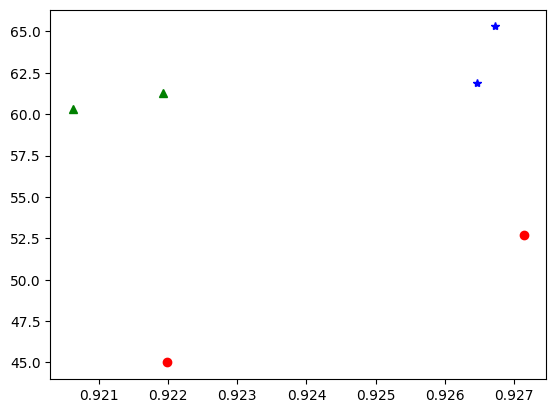

In [16]:
population_ = [x for x in population if not x.f == -1]
print(len(population_))
rank = [0 for _ in range(len(population_))]
for i in range(len(population_)):
        for j in range(i+1, len(population_)):
            if dominates(population_[i], population_[j]):
                rank[j] += 1
            elif dominates(population_[j], population_[i]):
                rank[i] += 1

rank_0 = []
rank_1 = []
rank_2 = []
rank_also = []
for r, ind in sorted(zip(rank, population_), key=lambda x: x[0]):
    if r == 0:
        rank_0.append(ind)
    elif r == 1:
        rank_1.append(ind)
    elif r == 2:
        rank_2.append(ind)
    else:
        rank_also.append(ind)

print(len(rank_0))
print(len(rank_1))
print(len(rank_2))
print(len(rank_also))

plt.plot([x.f for x in rank_0],[x.E for x in rank_0],'ro')
plt.plot([x.f for x in rank_1],[x.E for x in rank_1],'b*')
plt.plot([x.f for x in rank_2],[x.E for x in rank_2],'g^')

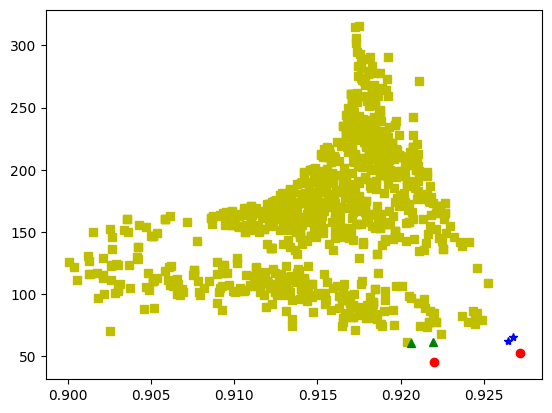

In [17]:
plt.plot([x.f for x in rank_also if x.f >0.9],[x.E for x in rank_also if x.f >0.9],'ys')
plt.plot([x.f for x in rank_2],[x.E for x in rank_2],'g^')
plt.plot([x.f for x in rank_1],[x.E for x in rank_1],'b*')
plt.plot([x.f for x in rank_0],[x.E for x in rank_0],'ro')

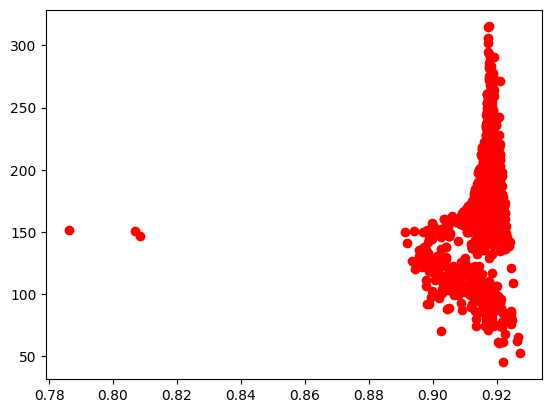

In [20]:
plt.plot([x.f for x in population],[x.E for x in population],'ro')

In [18]:
df.to_csv('out.csv')  
df.describe()

,f,E
count,1000.000000,1000.000000
mean,0.914348,164.480500
std,0.008551,50.100896
min,0.786135,45.000000
25%,0.912416,123.175000
50%,0.916081,163.550000
75%,0.918420,198.425000
max,0.927141,315.200000


In [19]:
for ind in rank_0:
    print(ind, f'Задача1задача2:ПутьВГрафеСети {ind.paths}')

f: 0.9271414477671346, E: 52.69999999999982, Распределение: [[5, 8], [], [7], [2], [6, 1, 4], [0], [3, 9]], Нагруженность на узлы: [0, 0, 0, 0, 0, 1250, 3750] Задача1задача2:ПутьВГрафеСети {'01': [6], '02': [6], '03': [6], '15': [6], '25': [6], '34': [6], '45': [6], '56': [6], '67': [6, 5], '68': [6, 5], '69': [6, 5], '78': [5], '89': [5]}
f: 0.9219904641621882, E: 45.0, Распределение: [[7, 4], [5, 8], [], [3, 9, 6], [], [2], [1, 0]], Нагруженность на узлы: [0, 0, 0, 0, 300, 200, 4400] Задача1задача2:ПутьВГрафеСети {'01': [6], '02': [6], '03': [6], '15': [6], '25': [6], '34': [6], '45': [6], '56': [6], '67': [6], '68': [6], '69': [6, 5, 4], '78': [6], '89': [6, 5, 4]}
